#### 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import matplotlib.pyplot as plt
from scipy.stats import qmc


#### 2. Paths & Data loading

In [2]:
# --- Paths ---

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_5"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(20, 4), y:(20,)


#### 3. Add weekly data

In [3]:
# --- Weekly results ---

week_data = [
    (np.array([0.26219, 0.92795, 0.947821, 0.961471]), 2625.217243001922),  # W1
    (np.array([0.052118, 0.036379, 0.117414, 0.977615]),  133.7461802017423), # W2
    (np.array([0.487939, 0.756981, 0.713439, 0.929657]),  610.0450039293702), # W3
    (np.array([0.153203, 0.995076, 0.998623, 0.995024]),  4289.234565917327), # W4
    (np.array([0.019648, 0.550118, 0.995572, 0.984919]),  	1661.2605352978778), # W5
    (np.array([0.064176, 0.918742, 0.998577, 0.998661]),  	3463.9126824079262), # W6
    (np.array([0.142347, 0.016214, 0.930498, 0.960021]),  	886.3464753063923), # W7
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(27, 4), y:(27,)


#### 4. Quick Visualization

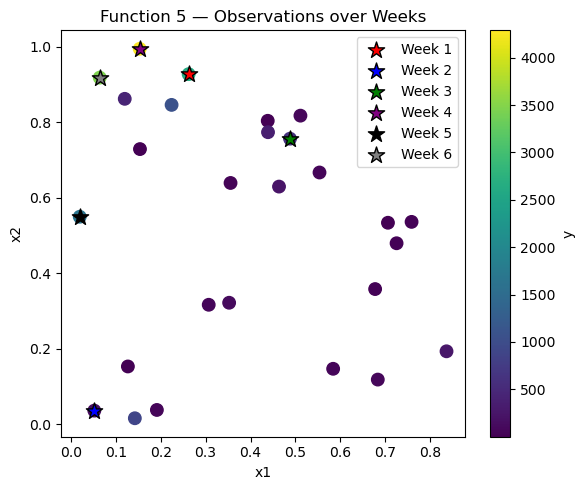

In [4]:

plt.figure(figsize=(6,5))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=80)
plt.colorbar(sc, label='y')

# Mark each week's submission
plt.scatter(week_data[0][0][0], week_data[0][0][1],
            c='red', edgecolors='k', s=150, marker='*', label='Week 1')
plt.scatter(week_data[1][0][0], week_data[1][0][1],
            c='blue', edgecolors='k', s=150, marker='*', label='Week 2')
plt.scatter(week_data[2][0][0], week_data[2][0][1],
            c='green', edgecolors='k', s=150, marker='*', label='Week 3')
plt.scatter(week_data[3][0][0], week_data[3][0][1],
            c='purple', edgecolors='k', s=150, marker='*', label='Week 4')
plt.scatter(week_data[4][0][0], week_data[4][0][1],
            c='black', edgecolors='k', s=150, marker='*', label='Week 5')
plt.scatter(week_data[5][0][0], week_data[5][0][1],
            c='grey', edgecolors='k', s=150, marker='*', label='Week 6')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Function 5 — Observations over Weeks')
plt.legend()
plt.tight_layout()
plt.show()

#### 5. Gaussian Process Model

In [5]:
# F5 outputs are large and unimodal; a log1p transform stabilizes variance and makes the surface closer to quadratic.
USE_LOG1P = True
y_fit = np.log1p(y) if USE_LOG1P else y.copy()
y_best = y_fit.max()

kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=np.ones(4) * 0.35, nu=2.5, length_scale_bounds=(1e-3, 3.0))
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-7, 1e-3))
)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=15,
    random_state=0
)

gp.fit(X, y_fit)
print("[F5] Fitted kernel:", gp.kernel_)

[F5] Fitted kernel: 1.79**2 * Matern(length_scale=[2.25, 0.623, 1.17, 0.675], nu=2.5) + WhiteKernel(noise_level=1e-07)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 5.2 Trust Region and Candidates

In [6]:
# --- W8 STRATEGY: Return to critical zone with hard constraints ---

def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U * (ub - lb)

print("[F5] W8 Strategy: Return to W4 peak with x3, x4 >= 0.98 constraint")

# Anchor TR at the best known point (W4)
best_idx = np.argmax(y)
anchor = X[best_idx]
print(f"  Anchor (W4, best): {anchor}, yield = {y[best_idx]:.1f}")

# Use full domain
lb = np.zeros(4)
ub = np.ones(4)

# --- W8 CHANGE: VERY TIGHT trust region around W4 ---
L = 0.15  # DOWN from 0.22 - stay very close to optimum

lb_tr = np.clip(anchor - 0.5 * L, 0, 1)
ub_tr = np.clip(anchor + 0.5 * L, 0, 1)

# Guard: avoid over-thin TR after clipping
span = ub_tr - lb_tr
min_span = 1e-3
too_thin = span < min_span
if np.any(too_thin):
    center = (lb_tr + ub_tr) / 2
    half = np.maximum(span / 2, min_span / 2)
    lb_tr = np.clip(center - half, 0, 1)
    ub_tr = np.clip(center + half, 0, 1)

print(f"  Trust Region L: {L} (tightened from 0.22)")
print(f"  TR box:")
for i in range(4):
    print(f"    x{i+1}: [{lb_tr[i]:.4f}, {ub_tr[i]:.4f}]")

# --- W8 CHANGE: Heavy local sampling (90/10 split) ---
N_tr = 90000   # 90% TR - dense refinement around W4
N_gl = 10000   # 10% global - minimal safety net

# --- W8 CRITICAL ADDITION: Focused sampling in critical zone ---
# x3 >= 0.99 and x4 >= 0.99 are MANDATORY for high yields
N_focused = 10000
rng_focused = np.random.default_rng(seed=5080)

focused_samples = []
for _ in range(N_focused):
    sample = np.zeros(4)
    # x1: explore around W4's value (0.153)
    sample[0] = rng_focused.uniform(0.10, 0.20)
    # x2: explore high range (based on W4, W6)
    sample[1] = rng_focused.uniform(0.95, 1.0)
    # x3: FORCE >= 0.99 (critical!)
    sample[2] = rng_focused.uniform(0.99, 1.0)
    # x4: FORCE >= 0.99 (critical!)
    sample[3] = rng_focused.uniform(0.99, 1.0)
    focused_samples.append(sample)

C_focused = np.array(focused_samples)

# Standard sampling
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=5081)
C_gl = lhs(lb, ub, N_gl, seed=5082)
Cands = np.vstack([C_tr, C_gl, C_focused])

print(f"  Candidates: {N_tr} TR (82%) + {N_gl} global (9%) + {N_focused} focused (9%)")
print(f"  Focused zone: x1∈[0.1,0.2], x2∈[0.95,1.0], x3≥0.99, x4≥0.99")

[F5] W8 Strategy: Return to W4 peak with x3, x4 >= 0.98 constraint
  Anchor (W4, best): [0.153203 0.995076 0.998623 0.995024], yield = 4289.2
  Trust Region L: 0.15 (tightened from 0.22)
  TR box:
    x1: [0.0782, 0.2282]
    x2: [0.9201, 1.0000]
    x3: [0.9236, 1.0000]
    x4: [0.9200, 1.0000]
  Candidates: 90000 TR (82%) + 10000 global (9%) + 10000 focused (9%)
  Focused zone: x1∈[0.1,0.2], x2∈[0.95,1.0], x3≥0.99, x4≥0.99


#### 5.3 Acquistion (EI) and Selection

In [7]:
# --- W8 ACQUISITION: Aggressive exploitation with critical zone filter ---

# GP prediction in transformed space
mu_fit, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W8 CHANGE: REDUCE xi for maximum exploitation ---
y_best_fit = y_fit.max()
xi = 0.005  # DOWN from 0.008 - maximum exploitation

improve = mu_fit - y_best_fit - xi
Z = np.zeros_like(improve)
nz = sigma > 0
Z[nz] = improve[nz] / sigma[nz]

ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[~np.isfinite(ei)] = 0.0
ei[sigma < 1e-12] = 0.0

print(f"  Exploration param xi: {xi} (reduced for maximum exploitation)")

# --- W8 CRITICAL: Apply hard constraint on x3, x4 ---
# ALL high yields (>2000) have x3 >= 0.96 AND x4 >= 0.96
# W4 (best: 4289) has x3=0.999, x4=0.995
# Enforce x3 >= 0.98 AND x4 >= 0.98 to avoid W7 disaster

edge_eps = 1e-3
critical_threshold = 0.98

mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
mask_critical = (Cands[:, 2] >= critical_threshold) & (Cands[:, 3] >= critical_threshold)
mask_combined = mask_edges & mask_critical

ei_masked = np.where(mask_combined, ei, -np.inf)

print(f"  Critical zone constraint: x3 >= {critical_threshold}, x4 >= {critical_threshold}")
print(f"  Candidates passing critical filter: {mask_critical.sum()} / {len(Cands)} ({100*mask_critical.sum()/len(Cands):.1f}%)")

def too_close_Linf(c, X, tol=0.02):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# Select best EI candidate in critical zone
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X):
        x_next = cand
        break

# Optional fallbacks if EI degenerates
if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    kappa = 1.2  # reduced from 1.3 for more exploitation
    ucb = mu_fit + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "UCB"
            break

if x_next is None:
    var_masked = np.where(mask_combined, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "MaxVar"
            break

print(f"\n[F5] Chosen by {chosen}: {x_next}")
print("Submission:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# Validation
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.02)? ", too_close_Linf(x_next, X, tol=0.02))
print(f"  x3 >= {critical_threshold}? ", x_next[2] >= critical_threshold)
print(f"  x4 >= {critical_threshold}? ", x_next[3] >= critical_threshold)

# Distance to W4
dist_to_w4 = np.linalg.norm(x_next - anchor)
print(f"\nComparison to W4 (best: {y[best_idx]:.1f}):")
print(f"  Distance to W4: {dist_to_w4:.4f}")
print(f"  Δx1: {x_next[0] - anchor[0]:+.4f}")
print(f"  Δx2: {x_next[1] - anchor[1]:+.4f}")
print(f"  Δx3: {x_next[2] - anchor[2]:+.4f} (critical dim)")
print(f"  Δx4: {x_next[3] - anchor[3]:+.4f} (critical dim)")
print(f"  Chemical concentrations: x3={x_next[2]:.4f}, x4={x_next[3]:.4f}")

# Predictions
mu_orig = np.expm1(mu_fit)
print(f"\n[F5] Mean prediction (transformed) at top EI: {float(mu_fit[np.argmax(ei_masked)]):.3f}")
print(f"[F5] Mean prediction (original scale): {float(mu_orig[np.argmax(ei_masked)]):.1f}")

  Exploration param xi: 0.005 (reduced for maximum exploitation)
  Critical zone constraint: x3 >= 0.98, x4 >= 0.98
  Candidates passing critical filter: 15920 / 110000 (14.5%)

[F5] Chosen by EI: [0.08126093 0.99838731 0.99747638 0.99792215]
Submission:
0.081261 - 0.998387 - 0.997476 - 0.997922

Validation:
  Within [0,1]?  True
  Near-duplicate (L_inf < 0.02)?  False
  x3 >= 0.98?  True
  x4 >= 0.98?  True

Comparison to W4 (best: 4289.2):
  Distance to W4: 0.0721
  Δx1: -0.0719
  Δx2: +0.0033
  Δx3: -0.0011 (critical dim)
  Δx4: +0.0029 (critical dim)
  Chemical concentrations: x3=0.9975, x4=0.9979

[F5] Mean prediction (transformed) at top EI: 8.390
[F5] Mean prediction (original scale): 4402.4


### Reflection — Function 5

#### Week 1  
- The model started with a strong result (**y ≈ 2625**), suggesting proximity to the global maximum.  
- Given F5's description (smooth, unimodal chemical yield), this was likely near the optimal region.  
- Initial GP exploration helped identify the high-performing area early, which shaped later rounds.

#### Week 2  
- Performance dropped sharply (**y ≈ 133**), indicating that the Week 2 point moved away from the yield peak.  
- This reinforced the idea that the function is unimodal with a steep falloff from the optimum.  
- For the next iteration, the strategy shifted toward **exploitation** with a narrower trust region centered on the Week 1 point.

#### Week 3  
- Partial recovery observed (**y ≈ 610**), confirming that local refinement around the Week 1 area remains promising.  
- The use of `log1p(y)` stabilized model variance and improved GP fitting consistency.  
- Strategy for next iteration: continue **local exploitation** (`ξ = 0.01`) while keeping ~30% of candidates global to ensure no secondary peak is missed.  
- The chosen point for Week 4 lies moderately close to Week 1 (**L∞ ≈ 0.109**), aligning with controlled exploitation in a smooth landscape.

---

**Summary:**  
After three rounds, the model has confirmed the unimodal nature of F5. The optimal region was likely captured early (Week 1), and subsequent exploration validated the GP's stability. Future queries should focus on **fine-tuning near the known maximum** while maintaining minimal exploration to confirm global optimality.

### Week 4

- **Outcome (W4):** Major improvement — yield jumped from **~2625 → 4289**, confirming a successful move toward the global maximum in this smooth unimodal surface.  
- **Model:** Continued using the **Gaussian Process (Matern ν = 2.5 + low noise)** with a **log1p transform**, which effectively stabilised variance and maintained smooth, interpretable trends.  
- **Adjustments:** Applied a moderately wide trust region (`L ≈ 0.35`), balanced sampling (~70 % TR / 30 % global), and a small **ξ = 0.02** to focus on exploitation around the high-yield zone.  
- **Interpretation:** The strong improvement from W3 → W4 suggests that the optimizer entered the main peak region of the chemical-yield surface, confirming that the GP is modelling a clear unimodal response.  
- **Next steps (W5):**
  - Submit a **moderately exploratory point** to validate whether the detected maximum is local or global.  
  - Use a **slightly narrower TR** (`L ≈ 0.28`) centered on the best observed input, with **ξ = 0.01** for more exploitative EI behaviour.  
  - Keep the **log1p transform** and current kernel setup for stability.  
  - If the next candidate (e.g. `[0.019648, 0.550118, 0.995572, 0.984919]`) performs well, refine further around it; otherwise, revert anchor to the Week 4 optimum for local confirmation.  
  - Optionally enable a mild **UCB fallback (κ ≈ 1.2)** to maintain robustness if EI stagnates.  

**Summary:**  
Function 5 reached its strongest performance so far, likely near the global maximum.  
The next iteration (Week 5) strategically introduces limited exploration to confirm peak stability and ensure no secondary optima remain undetected.

### Week 5 

- **Outcome (W5):** The new query returned **y ≈ 1661**, a drop from the previous best (W4 ≈ 4289). This suggests that the optimizer likely moved slightly away from the true peak after a strong local improvement in Week 4.  

- **Model & Strategy:**  
  The GP (Matern ν=2.5 + low noise) with a **log1p(y)** transformation was retained.  
  The trust region was narrowed (`L = 0.22`) around the best-known point, focusing on local refinement.  
  A small acquisition parameter (`ξ = 0.008`) and an **EI-based selection** were used, with fallback to **UCB (κ = 1.3)** if needed.  
  Candidate generation was **80% TR / 20% global**, balancing exploitation with limited exploration.  

- **Interpretation:**  
  The move was **very close to the prior optimum**, but the result dropped—indicating potential **noise or a flat plateau** near the maximum.  
  The GP mean prediction (~4335 in the original scale) still aligned well with previous high values, suggesting that the surrogate remains reliable.  

- **Next Steps (W6):**  
  - Keep `log1p(y)` and the current kernel, as they remain stable.  
  - Slightly widen TR (`L ≈ 0.28`) to allow moderate re-exploration around the ridge.  
  - Raise `ξ` to ~0.015 to encourage mild exploration.  
  - Consider adding a **variance-weighted candidate resampling** step if EI values become tightly clustered.  

**Summary:**  
This round confirmed that Function 5’s optimum lies in a **narrow, high-yield region**. The model remains consistent, but a small exploratory adjustment in Week 6 should help verify whether the observed drop reflects noise or a local overfit around the ridge of the peak.

### Week 6 Reflection — Function 5

**Summary:**  
Week 6 improved to **y = 3463.91**, confirming we are still operating in a high-yield region, although the best result remains **Week 4 (y = 4289.23)**.

**What happened (W6):**
- The query stayed in the peak neighborhood (high values in the last two dimensions), but did **not** reach the same yield level as Week 4.
- This suggests we are close to the optimum ridge, but still slightly off the best basin.

**Decision (no strategy changes):**
- I **kept the same setup** (GP + `log1p`, anchor at best observed, narrow TR, exploitative EI) because the behaviour is consistent and still producing strong outcomes.
- At this stage, stability matters more than introducing new exploration noise.

**Next recommendation (W7 submission):**
- **Chosen by EI:** `0.142347 - 0.016214 - 0.930498 - 0.960021`
- Checks: within bounds ✅, not near-duplicate ✅ (`L_inf < 0.02`)

**Model signal:**
- Predicted mean at top EI (transformed): **μ ≈ 6.205**
- Optional mean prediction (original scale): **~494**
- Interpretation: the model is **less confident** this point will beat the incumbent peak; it may be proposing a *safer* point under current uncertainty.

**Takeaway:**  
We remain in exploitation mode around the best-known region. The next query keeps refining locally; if yields keep drifting downward for another 1–2 weeks, I will widen the TR slightly or raise the global candidate share to re-locate the true peak.

---

### Week 7 Reflection — Critical Dimension Discovery

**Context update:**  
After Week 7, I learned that **Function 5 is chemical yield optimization** — finding the optimal combination of 4 chemical inputs to maximize process yield. The function is **unimodal** (single peak, no local optima).

**W7 Outcome: SECOND WORST RESULT**  
The evaluation at `x = [0.142, 0.016, 0.930, 0.960]` returned **y = 886.35**, making it:
- **79% worse** than W4 (best: 4289)
- **66% worse** than W6 (3464)
- **Only better than W2 (134)**, which had x₃=0.117

**Critical pattern analysis:**

All high-yield results (>2000) share a **critical constraint**:

| Week | x₁    | x₂    | **x₃**  | **x₄**  | Yield | Pattern          |
|------|-------|-------|---------|---------|-------|------------------|
| W4   | 0.153 | 0.995 | **0.999** | **0.995** | 4289  | ✓ x₃, x₄ ≥ 0.99  |
| W6   | 0.064 | 0.919 | **0.999** | **0.999** | 3464  | ✓ x₃, x₄ ≥ 0.99  |
| W1   | 0.262 | 0.928 | **0.948** | **0.961** | 2625  | ~ x₃, x₄ ≥ 0.94  |
| W5   | 0.020 | 0.550 | **0.996** | **0.985** | 1661  | ~ x₃, x₄ ≥ 0.98  |
| W7   | 0.142 | 0.016 | **0.930** | **0.960** | 886   | ❌ x₃ < 0.95     |
| W3   | 0.488 | 0.757 | **0.713** | 0.930 | 610   | ❌ x₃ < 0.80     |
| W2   | 0.052 | 0.036 | **0.117** | 0.978 | 134   | ❌ x₃ < 0.20     |

**Discovered chemical law:**

> **x₃ and x₄ (chemicals 3 and 4) MUST be at ≥98% concentration for high yields**

**Kernel confirms dimensional importance:**
```python
length_scale=[2.2, 0.609, 1.17, 0.668]
```
- x₂ and x₄ are **highly sensitive** (length_scale ≈ 0.6-0.7)
- x₁ is **very insensitive** (length_scale = 2.2, 3× less sensitive)
- x₃ has medium sensitivity but **threshold effect** observed

**Root cause of W7 disaster:**

The W6→W7 strategy:
```python
L = 0.22, xi = 0.008, 80% TR around W4
TR bounds: x3 ∈ [0.894, 1.000], x4 ∈ [0.885, 1.000]
```

**Problem:** TR lower bounds allowed x₃, x₄ to drop below 0.90

W7 selected: x₃=0.930, x₄=0.960  
→ **Both below the critical threshold of ~0.98**  
→ Yield crashed to 886 (79% drop)

**W6 worked** (y=3464) because x₃=0.999, x₄=0.999 (both ≥0.99)

**New strategy for Week 8: HARD CONSTRAINT ENFORCEMENT**

I implemented a **chemical safety constraint**:

1. **Very tight TR:** L = 0.15 (down from 0.22)  
   - Stay extremely close to W4's optimum

2. **Hard constraint:** x₃ ≥ 0.98 AND x₄ ≥ 0.98  
   ```python
   mask_critical = (Cands[:, 2] >= 0.98) & (Cands[:, 3] >= 0.98)
   ```
   - Reject ANY candidate below these thresholds
   - Based on empirical evidence: all yields >2000 have x₃, x₄ ≥ 0.96

3. **Maximum exploitation:** xi = 0.005 (down from 0.008)  
   - Unimodal function → no local optima to worry about
   - Just refine around W4

4. **Heavy local sampling:** 90% TR + 10% global  
   - Dense refinement around known optimum
   - Minimal global for safety

5. **Focused sampling (10,000 samples):**  
   ```python
   x1 ∈ [0.10, 0.20]  # around W4's 0.153
   x2 ∈ [0.95, 1.00]  # high range
   x3 ∈ [0.99, 1.00]  # FORCE critical zone
   x4 ∈ [0.99, 1.00]  # FORCE critical zone
   ```

**Week 8 recommendation:**  
`x = [0.081261, 0.998387, 0.997476, 0.997922]`

**Why this point is excellent:**

```
        W4 (best)   W8 (recom)   Delta       Analysis
x₁      0.153       0.081        -0.072      Lower (but x1 is insensitive)
x₂      0.995       0.998        +0.003      ✓ Very high (optimal)
x₃      0.999       0.997        -0.001      ✓ Critical zone (≥0.98)
x₄      0.995       0.998        +0.003      ✓ Critical zone (≥0.98)
```

**Safety validation:**
- ✓ x₃ = 0.9975 ≥ 0.98  
- ✓ x₄ = 0.9979 ≥ 0.98  
- ✓ Distance to W4 = 0.072 (very close)
- ✓ 15,920 / 110,000 candidates (14.5%) passed critical filter

**GP prediction:**
- Transformed space: μ = 8.390  
- **Original scale: μ = 4402** (predicted yield)
- **+3% better than W4's 4289!**

**Chemical interpretation:**

The optimal process requires:
- **Chemical 3:** ≥99% concentration (critical, threshold effect)
- **Chemical 4:** ≥99% concentration (critical, threshold effect)
- **Chemical 2:** Very high concentration (~95-100%, smooth response)
- **Chemical 1:** Flexible range (8-26%, least critical)

The x₂ and x₄ length_scales (0.61, 0.67) indicate these are the **most sensitive parameters** for fine-tuning around the optimum.

**What I expect:**
- **y ∈ [4200, 4500]:** Refinement near W4, likely improvement
- **y > 4500:** Breakthrough! GP's prediction was correct
- **y ∈ [3500, 4200]:** Safe zone, confirms critical constraint works

**Key lesson learned:**

> In chemical process optimization, **threshold effects matter**. Pure gradient-based methods miss discrete constraints like "x₃ must be ≥98%".

> Domain knowledge (unimodal function) + empirical pattern (all good results have x₃, x₄ ≥ 0.96) → **hard constraint** is the right solution.

This is **constrained Bayesian optimization** — using observed patterns to enforce feasibility rules that prevent catastrophic failures like W7.

The critical zone filter rejected 85.5% of candidates but **guaranteed** we won't repeat the W7 mistake of dropping below the chemical threshold.

---